In [37]:
import os
import pandas as pd
import re
import csv
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

In [4]:
def load_creddata(meta_dir="meta"):
    # Load all metadata CSVs
    meta_files = [f for f in os.listdir(meta_dir) if f.endswith(".csv")]
    df_list = []

    for meta_file in meta_files:
        df = pd.read_csv(os.path.join(meta_dir, meta_file))
        df_list.append(df)

    metadata = pd.concat(df_list, ignore_index=True)

    file_contents = []
    processed_repos = set()
    total_rows = len(metadata)

    for idx, row in metadata.iterrows():
        repo_id = row["RepoName"]
        if repo_id not in processed_repos:
            processed_repos.add(repo_id)
            print(f"Processing repository {len(processed_repos)} / {metadata['RepoName'].nunique()}: {repo_id}")

        data_path = row["FilePath"]
        if not os.path.exists(data_path):
            print(f"Warning: data file for {repo_id} / {row['FileID']} not found, skipping.")
            continue

        try:
            with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read()
        except Exception as e:
            print(f"Error reading {data_path}: {e}")
            continue

        file_contents.append({
            "Id": row["Id"],
            "RepoName": repo_id,
            "FileID": row["FileID"],
            "FilePath": data_path,
            "Content": content,
            "LineStart": row["LineStart"],
            "LineEnd": row["LineEnd"],
            "GroundTruth": row["GroundTruth"],
            "ValueStart": row["ValueStart"],
            "ValueEnd": row["ValueEnd"],
            "Category": row.get("Category", None)
        })

    df = pd.DataFrame(file_contents)

    # Summarize dataset
    total_files = df["FilePath"].nunique()
    total_lines = df["Content"].apply(lambda x: len(x.splitlines())).sum()
    label_counts = df["GroundTruth"].value_counts()

    print("\nDataset Summary")
    print(f"Total repositories processed: {len(processed_repos)}")
    print(f"Total files loaded: {total_files}")
    print(f"Total lines of code: {total_lines}")
    print("GroundTruth counts:")
    print(label_counts)

    return df

In [5]:
df = load_creddata()
print(df.head())

Processing repository 1 / 318: 00408ef6
Processing repository 2 / 318: 0064e882
Processing repository 3 / 318: 02dfa7ec
Processing repository 4 / 318: 0401c075
Processing repository 5 / 318: 0436af4a
Processing repository 6 / 318: 5.357e+91
Processing repository 7 / 318: 057480bf
Processing repository 8 / 318: 06dd1bf2
Processing repository 9 / 318: 7.715e+95
Processing repository 10 / 318: 08295bf0
Processing repository 11 / 318: 0a0d22aa
Processing repository 12 / 318: 0b0a8cd6
Processing repository 13 / 318: 0ce78112
Processing repository 14 / 318: 0de15ccf
Processing repository 15 / 318: 0f133e09
Processing repository 16 / 318: 0fc802c8
Processing repository 17 / 318: 106c7cd2
Processing repository 18 / 318: 110f8d35
Processing repository 19 / 318: 1.1774e+82
Processing repository 20 / 318: 16fc0238
Processing repository 21 / 318: 177cf0f9
Processing repository 22 / 318: 19d43369
Processing repository 23 / 318: 1a2de400
Processing repository 24 / 318: 1ca5e942
Processing repository

In [6]:
def map_groundtruth(df):
    df['Label'] = df['GroundTruth'].map({'F': 0, 'T': 1, 'X': 0})
    return df

# Candidate Extraction with labels
def extract_candidates_with_labels(df, output_file="candidates_with_labels.csv", max_repos=30):
    """
    Extract tokens from files and label them using GroundTruth.
    """
    df = map_groundtruth(df)
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Repo', 'FilePath', 'Line', 'Token', 'Label', 'Category'])

        repos = df['RepoName'].unique()[:max_repos]  # subset of repos

        for repo_index, repo in enumerate(repos, start=1):
            repo_df = df[df['RepoName'] == repo]
            count = 0

            for _, row in repo_df.iterrows():
                content = row['Content']
                line_number = row['LineStart']
                gt_start = row['ValueStart']
                gt_end = row['ValueEnd']
                label = row['Label']
                category = row.get('Category', None)

                # Add GroundTruth secret as a token (positive example)
                if label == 1 and pd.notna(gt_start) and pd.notna(gt_end):
                    secret_token = content[int(gt_start):int(gt_end)]
                    if secret_token.strip():  # skip empty
                        writer.writerow([repo, row['FilePath'], line_number, secret_token, 1, category])
                        count += 1

                # Regex candidates (negative examples)
                candidates = re.findall(r'["\']([^"\']{3,128})["\']', content)
                candidates += re.findall(r'\b[a-zA-Z0-9_]{8,64}\b', content)
                candidates = [t for t in candidates if t.strip() and ' ' not in t]

                for token in candidates:
                    # skip if exactly the secret token already added
                    if label == 1 and pd.notna(gt_start) and pd.notna(gt_end):
                        if token == secret_token:
                            continue
                    writer.writerow([repo, row['FilePath'], line_number, token, 0, category])
                    count += 1

            print(f"[{repo_index}/{len(repos)}] Saved {count} candidates for repo {repo}")

    print("Candidate extraction completed.")

In [7]:
def compute_features(token):
    token = "" if pd.isna(token) else str(token)

    length = len(token)
    num_digits = sum(c.isdigit() for c in token)
    num_upper = sum(c.isupper() for c in token)
    num_lower = sum(c.islower() for c in token)
    num_special = sum(not c.isalnum() for c in token)

    entropy = 0
    if length > 0:
        probs = [token.count(c)/length for c in set(token)]
        entropy = -sum(p * math.log2(p) for p in probs)

    return {
        'length': length,
        'num_digits': num_digits,
        'num_upper': num_upper,
        'num_lower': num_lower,
        'num_special': num_special,
        'entropy': entropy
    }


def build_feature_dataset(candidates_csv="candidates_with_labels.csv",
                          features_csv="training_features.csv"):
    df = pd.read_csv(candidates_csv)
    feature_rows = []

    for _, row in df.iterrows():
        feats = compute_features(row['Token'])
        feats.update({
            'Repo': row['Repo'],
            'FilePath': row['FilePath'],
            'Line': row['Line'],
            'Token': row['Token'],
            'Label': row['Label'],
            'Category': row['Category']
        })
        feature_rows.append(feats)

    features_df = pd.DataFrame(feature_rows)
    features_df.to_csv(features_csv, index=False)
    print(f"Saved ML feature dataset to {features_csv}")
    return features_df

In [8]:
def regex_candidates(content):
    candidates = re.findall(r'["\']([^"\']{3,128})["\']', content)
    candidates += re.findall(r'\b[a-zA-Z0-9_\-/.]{8,64}\b', content)
    return [t for t in candidates if t.strip() and ' ' not in t]

def entropy(token):
    token = str(token)
    if not token:
        return 0
    length = len(token)
    probs = [token.count(c)/length for c in set(token)]
    return -sum(p * math.log2(p) for p in probs)

def regex_entropy_predict(content, threshold=2.5):
    """Return candidate tokens with entropy >= threshold"""
    return [t for t in regex_candidates(content) if entropy(t) >= threshold]

In [9]:
def train_random_forest(features_df, negative_ratio=50, n_estimators=50):
    # Split positives and negatives
    positives = features_df[features_df['Label'] == 1]
    negatives = features_df[features_df['Label'] == 0]

    # Downsample negatives
    if len(negatives) > len(positives) * negative_ratio:
        negatives = negatives.sample(n=len(positives) * negative_ratio, random_state=42)

    balanced_df = pd.concat([positives, negatives]).sample(frac=1, random_state=42)  # shuffle

    # Features and labels
    X = balanced_df[['length','num_digits','num_upper','num_lower','num_special','entropy']]
    y = balanced_df['Label']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Random Forest
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, preds))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    return clf

In [10]:
def train_logistic_regression(features_df, negative_ratio=50):
    # Split positives and negatives
    positives = features_df[features_df['Label'] == 1]
    negatives = features_df[features_df['Label'] == 0]

    # Downsample negatives
    if len(negatives) > len(positives) * negative_ratio:
        negatives = negatives.sample(n=len(positives) * negative_ratio, random_state=42)

    balanced_df = pd.concat([positives, negatives]).sample(frac=1, random_state=42)

    # Select features and labels
    X = balanced_df[['length','num_digits','num_upper','num_lower','num_special','entropy']]
    y = balanced_df['Label']

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Logistic Regression (balanced for imbalanced data)
    clf = LogisticRegression(
        class_weight='balanced',
        max_iter=500,
        solver='liblinear'  # good for small & imbalanced datasets
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nLogistic Regression Report")
    print(classification_report(y_test, preds))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    return clf

In [ ]:
FEATURE_COLS = [
    'length',
    'num_digits',
    'num_upper',
    'num_lower',
    'num_special',
    'entropy'
]

def prepare_balanced_data(features_df, negative_ratio=50):
    positives = features_df[features_df['Label'] == 1]
    negatives = features_df[features_df['Label'] == 0]

    if len(negatives) > len(positives) * negative_ratio:
        negatives = negatives.sample(
            n=len(positives) * negative_ratio,
            random_state=42
        )

    df = pd.concat([positives, negatives]).sample(frac=1, random_state=42)

    X = df[FEATURE_COLS]
    y = df['Label']

    return train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

# Gradient Boosting Classifier
def train_gradient_boosting(features_df, negative_ratio=50):
    X_train, X_test, y_train, y_test = prepare_balanced_data(
        features_df, negative_ratio
    )

    clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nGradient Boosting Report")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    return clf

# Naive Bayes Classifier
def train_naive_bayes(features_df, negative_ratio=50):
    X_train, X_test, y_train, y_test = prepare_balanced_data(
        features_df, negative_ratio
    )

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nNaive Bayes Report")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    return clf


In [11]:
extract_candidates_with_labels(df, output_file="candidates_with_labels.csv")

[1/30] Saved 195527 candidates for repo 00408ef6
[2/30] Saved 22673 candidates for repo 0064e882
[3/30] Saved 99890 candidates for repo 02dfa7ec
[4/30] Saved 56726 candidates for repo 0401c075
[5/30] Saved 126844 candidates for repo 0436af4a
[6/30] Saved 224 candidates for repo 5.357e+91
[7/30] Saved 10626 candidates for repo 057480bf
[8/30] Saved 205991 candidates for repo 06dd1bf2
[9/30] Saved 17915 candidates for repo 7.715e+95
[10/30] Saved 8548 candidates for repo 08295bf0
[11/30] Saved 3692 candidates for repo 0a0d22aa
[12/30] Saved 259186 candidates for repo 0b0a8cd6
[13/30] Saved 5958 candidates for repo 0ce78112
[14/30] Saved 234615 candidates for repo 0de15ccf
[15/30] Saved 12526523 candidates for repo 0f133e09
[16/30] Saved 22642 candidates for repo 0fc802c8
[17/30] Saved 77459 candidates for repo 106c7cd2
[18/30] Saved 59949 candidates for repo 110f8d35
[19/30] Saved 910 candidates for repo 1.1774e+82
[20/30] Saved 29926 candidates for repo 16fc0238
[21/30] Saved 14460 cand

In [12]:
features_df = build_feature_dataset(candidates_csv="candidates_with_labels.csv",
                                    features_csv="training_features.csv")

Saved ML feature dataset to training_features.csv


In [13]:
model = train_random_forest(features_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4930
           1       0.44      0.75      0.56        99

    accuracy                           0.98      5029
   macro avg       0.72      0.86      0.77      5029
weighted avg       0.98      0.98      0.98      5029

Confusion Matrix:
[[4837   93]
 [  25   74]]


In [14]:
model_lr = train_logistic_regression(features_df)


Logistic Regression Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      4930
           1       0.14      0.85      0.24        99

    accuracy                           0.90      5029
   macro avg       0.57      0.87      0.59      5029
weighted avg       0.98      0.90      0.93      5029

Confusion Matrix:
[[4425  505]
 [  15   84]]


In [19]:
model_gb = train_gradient_boosting(features_df)


Gradient Boosting Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4930
           1       0.92      0.67      0.77        99

    accuracy                           0.99      5029
   macro avg       0.96      0.83      0.88      5029
weighted avg       0.99      0.99      0.99      5029

Confusion Matrix:
[[4924    6]
 [  33   66]]


In [24]:
model_nb = train_naive_bayes(features_df)


Naive Bayes Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4930
           1       0.07      0.24      0.11        99

    accuracy                           0.93      5029
   macro avg       0.53      0.59      0.54      5029
weighted avg       0.97      0.93      0.94      5029

Confusion Matrix:
[[4634  296]
 [  75   24]]


In [28]:
subset_repos = df['RepoName'].unique()[:30]  # first 30 repos

y_true = []
y_pred = []
start_time = time.time()

for repo in subset_repos:
    repo_df = df[df['RepoName'] == repo]
    for _, row in repo_df.iterrows():
        y_true.append(1 if row['GroundTruth'] == 'T' else 0)

        predicted_tokens = regex_entropy_predict(row['Content'])
        
        if row['GroundTruth'] == 'T' and pd.notna(row['ValueStart']) and pd.notna(row['ValueEnd']):
            secret_token = row['Content'][int(row['ValueStart']):int(row['ValueEnd'])]
            pred = 1 if secret_token in predicted_tokens else 0
        else:
            pred = 1 if len(predicted_tokens) > 0 else 0
        
        y_pred.append(pred)

end_time = time.time()
scan_time = (end_time - start_time) / len(subset_repos)  # avg time per repo

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Regex + Entropy (baseline) -> Precision: {precision:.2f}, Recall: {recall:.2f}, "
      f"F1: {f1:.2f}, Avg scan time: {scan_time:.2f}s")

Regex + Entropy (baseline) -> Precision: 0.00, Recall: 0.01, F1: 0.00, Avg scan time: 1.84s


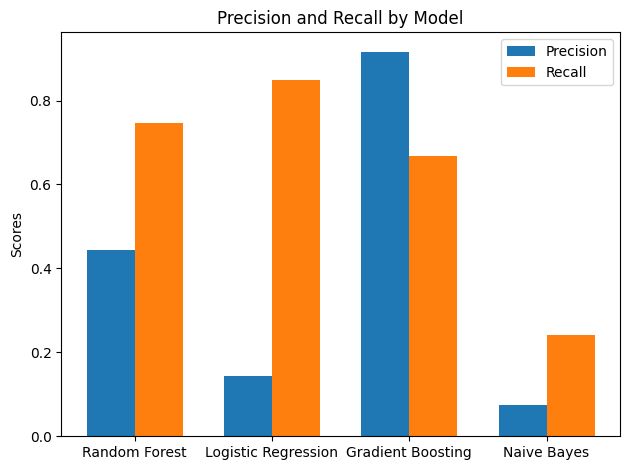

In [ ]:
# Graph the models Precision vs Recall

models = {
    'Random Forest': model,
    'Logistic Regression': model_lr,
    'Gradient Boosting': model_gb,
    'Naive Bayes': model_nb
}
precision_scores = []
recall_scores = []
for name, mdl in models.items():
    X_train, X_test, y_train, y_test = prepare_balanced_data(features_df)
    preds = mdl.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision_scores.append(precision)
    recall_scores.append(recall)
# Plotting
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision_scores, width, label='Precision')
rects2 = ax.bar(x + width/2, recall_scores, width, label='Recall')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall by Model')
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend()
fig.tight_layout()
plt.show()

In [23]:
print("===== Dataset Overview =====")
print(f"Total repositories: {df['RepoName'].nunique()}")
print(f"Total files: {df['FilePath'].nunique()}")
print(f"Total lines of code: {df['Content'].apply(lambda x: len(x.splitlines())).sum()}")
print("\nGroundTruth label distribution:")
print(df['GroundTruth'].value_counts())

===== Dataset Overview =====
Total repositories: 318
Total files: 9639
Total lines of code: 224443513

GroundTruth label distribution:
GroundTruth
F    39806
T    13615
X     3859
Name: count, dtype: int64


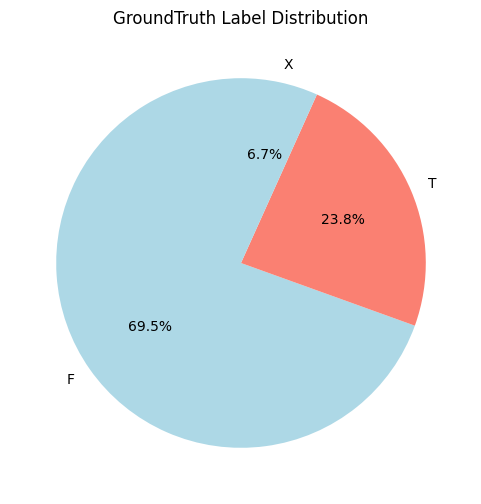

In [8]:
plt.figure(figsize=(6,6))
df['GroundTruth'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue','salmon'])
plt.title("GroundTruth Label Distribution")
plt.ylabel('')
plt.show()

In [33]:
ABLATIONS = {
    "All features": [
        'length',
        'num_digits',
        'num_upper',
        'num_lower',
        'num_special',
        'entropy'
    ],
    "No entropy": [
        'length',
        'num_digits',
        'num_upper',
        'num_lower',
        'num_special'
    ],
    "No length": [
        'num_digits',
        'num_upper',
        'num_lower',
        'num_special',
        'entropy'
    ],
    "No special": [
        'length',
        'num_digits',
        'num_upper',
        'num_lower',
        'entropy'
    ],
    "Only composition (no length, no entropy)": [
        'num_digits',
        'num_upper',
        'num_lower',
        'num_special'
    ],
    "Only scalar (length + entropy)": [
        'length',
        'entropy'
    ]
}

In [34]:
def extract_positive_metrics(y_test, preds):
    report = classification_report(y_test, preds, output_dict=True)
    return {
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"]
    }

In [35]:
def run_gradient_boosting_ablation(features_df, negative_ratio=50):
    global FEATURE_COLS

    results = []

    for name, cols in ABLATIONS.items():
        print(f"\n=== Running ablation: {name} ===")

        FEATURE_COLS = cols  # 🔑 ONLY change

        X_train, X_test, y_train, y_test = prepare_balanced_data(
            features_df, negative_ratio
        )

        clf = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        metrics = extract_positive_metrics(y_test, preds)
        metrics["Model"] = name
        results.append(metrics)

    return pd.DataFrame(results)

In [36]:
ablation_results = run_gradient_boosting_ablation(features_df)
ablation_results


=== Running ablation: All features ===

=== Running ablation: No entropy ===

=== Running ablation: No length ===

=== Running ablation: No special ===

=== Running ablation: Only composition (no length, no entropy) ===

=== Running ablation: Only scalar (length + entropy) ===


,precision,recall,f1,Model
0,0.916667,0.666667,0.771930,All features
1,0.907692,0.595960,0.719512,No entropy
2,0.888889,0.565657,0.691358,No length
3,0.979592,0.484848,0.648649,No special
4,0.919355,0.575758,0.708075,"Only composition (no length, no entropy)"
5,0.968750,0.313131,0.473282,Only scalar (length + entropy)


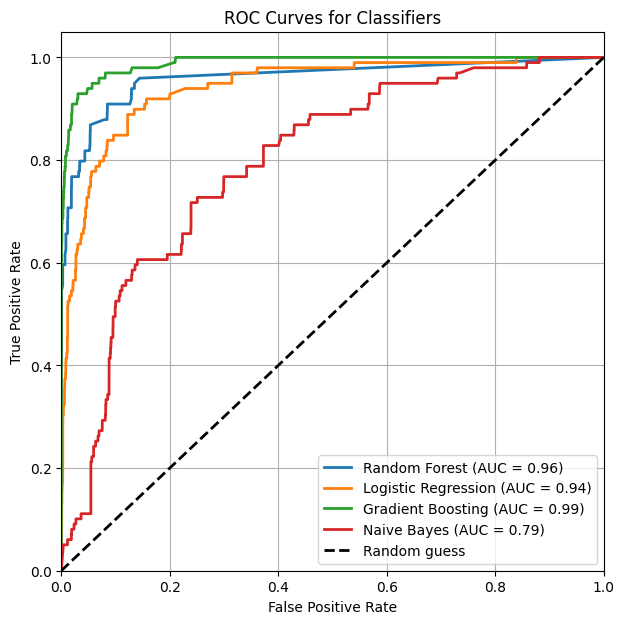

In [39]:
FEATURE_COLS = [
    'length',
    'num_digits',
    'num_upper',
    'num_lower',
    'num_special',
    'entropy'
]

# Prepare the data (same split as training)
X_train, X_test, y_train, y_test = prepare_balanced_data(features_df)

# Dictionary to store models
models = {
    "Random Forest": model,
    "Logistic Regression": model_lr,
    "Gradient Boosting": model_gb,
    "Naive Bayes": model_nb
}

plt.figure(figsize=(7,7))

for name, clf in models.items():
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Random guessing line
plt.plot([0,1], [0,1], 'k--', lw=2, label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()